# 5. Machine Learning Models for TLC Prediction

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdChemReactions, rdmolops
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score

## 5.1 Feature Selection and Preparation

In [2]:
def create_fingerprints(df: pd.DataFrame, column_name: str):
    """Function that creates Morgan Fingerprint, MACCS Fingerprints and RDKit Fingerprints for the extracted product molecules in the dataframe.

    Args:
        df (pd.DataFrame): dataframe containing the cleaned and extracted product SMILES
        column_name (str): column name of the SMILES column to be converted
    """
    radius = 3 # Radius of the fingerprint
    
    if column_name in ['Solvent_A_Smiles', 'Solvent_B_Smiles']:
        n_bits_morgan = 256 # shorter fingerprint for solvents
    else: 
        n_bits_morgan = 2048 # Fingerprint length for product column (more complex info needed)
        
    n_bits_rdkit = 2048
    
    
    def safe_morgan(x):
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_morgan, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_morgan, dtype=int)
        else:
            arr = np.zeros((n_bits_morgan,), dtype=int)
            morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits_morgan)
            DataStructs.ConvertToNumpyArray(morgan, arr) #wichtig, no return sondern arr wird ueberschrieben, deshalb return arr
            return arr
    
    def safe_rdkit(x):
        arr = np.zeros((2048,), dtype=int)
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_rdkit, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_rdkit, dtype=int)
        return Chem.RDKFingerprint(mol, maxPath=5, fpSize=n_bits_rdkit)
    
    def rdkit_descriptors(x):
        if x is None or not isinstance(x, str):
            return np.zeros(4)
        mol = Chem.MolFromSmiles(x)
        if mol:
            return np.array([Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                             Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol)])
        return np.zeros(4)
    
    df_new = df.copy()
    df_new[column_name + '_Morgan_Fingerprint_np'] = df[column_name].apply(safe_morgan)
    #df_new[column_name +'_RDKit_Fingerprint'] = df[column_name].apply(safe_rdkit)
    df_new[column_name + '_RDKit_Descriptors'] = df[column_name].apply(rdkit_descriptors)
    
    return df_new

In [17]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp.shape

(15063, 17)

In [18]:
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_fp['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [5]:
df_fp.columns

Index(['Unnamed: 0', 'paragraphText', 'reactionSmiles', 'productSmiles',
       'title', 'Rf', 'Solvent_A', 'Solvent_B', 'Percent_A', 'Percent_B',
       'Additive_C', 'Percent_C', 'sum', 'Solvent_A_Smiles',
       'Solvent_B_Smiles', 'extracted_pr_Smiles', 'productSmiles_processed'],
      dtype='object')

In [19]:
# apply fingerprint generation function
df_fp = create_fingerprints(df_fp, 'productSmiles_processed')
df_fp = create_fingerprints(df_fp, 'Solvent_A_Smiles')
df_fp = create_fingerprints(df_fp, 'Solvent_B_Smiles')

# convert the percent values to numpy arrays
df_fp['Percent_A'] = df_fp['Percent_A'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
df_fp['Percent_B'] = df_fp['Percent_B'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# show the dataframe
df_fp.head(5)

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,...,Solvent_A_Smiles,Solvent_B_Smiles,extracted_pr_Smiles,productSmiles_processed,productSmiles_processed_Morgan_Fingerprint_np,productSmiles_processed_RDKit_Descriptors,Solvent_A_Smiles_Morgan_Fingerprint_np,Solvent_A_Smiles_RDKit_Descriptors,Solvent_B_Smiles_Morgan_Fingerprint_np,Solvent_B_Smiles_RDKit_Descriptors
0,2,A solution of 4-{[(phenylmethoxy)carbonylamino...,[C:1]1([CH2:7][O:8][C:9]([NH:11][CH2:12][C:13]...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],Preparation of N-methoxy-N-methyl(4-{[(phenylm...,[0.3],petroleum ether (2-methylpentane),EtOAc,[50.0],[50.0],...,CCCC(C)C,O=C(OCC)C,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[328.36799999999994, 2.7464000000000013, 1.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.442500000000001, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]"
1,3,Putative nitrilase up-mutants were assayed in ...,[CH3:1][C:2]1(C)S[C@@H]2[C@H](NC([C@H](N)C3C=C...,['N#CC[C@@H](O)CC(=O)O'],NaN,[0.5],EtOAc,Hexane,[50.0],[50.0],...,O=C(OCC)C,CCCCCC,['N#CC[C@@H](O)CC(=O)O'],N#CC[C@@H](O)CC(=O)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[129.115, -0.26431999999999994, 2.0, 3.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
2,5,To 0.4 g N6-benzoyl-3′-O-(methylthiomethyl)-5′...,[C:1]([NH:9][C:10]1[C:11]2[N:12]=[CH:13][N:14]...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,NaN,[0.3],EtOAc,Hexane,[70.0],[30.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cccc...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[410.3940000000001, 2.0114000000000005, 2.0, 9.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
3,6,3.5 g N4-benzoyl-5′-O-tert-butyldimethylsilyl-...,[C:1]([NH:9][C:10]1[CH:30]=[CH:29][N:13]([C@@H...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,NaN,[0.4],EtOAc,Hexane,[90.0],[10.0],...,O=C(OCC)C,CCCCCC,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)O[...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[505.7130000000003, 4.510600000000005, 1.0, 8.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
4,7,To 0.5580 g N4-benzoyl-3′-O-(methylthiomethyl)...,[C:1]([NH:9][C:10]1[CH:33]=[CH:32][N:13]([C@@H...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,NaN,[0.5],EtOAc,Hexane,[5.0],[95.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[386.36800000000017, 1.4283999999999997, 2.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"


In [7]:
print(type(df_fp['Percent_A'][0]))

<class 'numpy.ndarray'>


concatenate the np.arrays into larger 2D arrays for an X set (features) and a y set with the corresponding Rf values. 

In [20]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
# percent A and B are already in the correct format

# concatenate all the 2D numpy arrays to a big 2D numpy array
features = np.concatenate([compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(features.shape, type(features), features.ndim, y.ndim, y.shape)


(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2
(15062, 2562) <class 'numpy.ndarray'> 2 2 (15062, 1)


## 5.2 FCNN Model

In [3]:
# imports for the FCNN model
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.optim as optim
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from transformers import AutoTokenizer, AutoModel


In [31]:
class FCNN(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 64)    # Hidden layer 2
        self.fc4 = nn.Linear(64, 1)      # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        #self.linear = nn.Linear()
        #self.hard_sigmoid = nn.Hardsigmoid()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        # x = self.hard_sigmoid(self.fc4(x))
        x =  self.sigmoid(self.fc4(x))               # Softplus to ensure positive values? hard_sigmoid: self.hard_sigmoid(self.fc4(x))
        return x

In [34]:
class SimpleFCNN(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Input layer
        self.fc2 = nn.Linear(256, 1)  # Output layer

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [5]:
class FCNN_deep(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN_deep, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)  
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1) # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.hard_sigmoid = nn.Hardsigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.relu(self.fc4(x)) 
        x = self.dropout_3(x)
        x = self.relu(self.fc5(x)) 
        x = self.dropout_3(x)
        x = self.hard_sigmoid(self.fc6(x)) # or no activation?
        return x

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, head_dim)

        # Einsum does matrix mult. for query*keys for each batch and each head
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, head_dim),
        # keys shape: (N, key_len, heads, head_dim)
        # energy shape: (N, heads, query_len, key_len)

        attention = torch.softmax(energy / (self.embed_size ** (0.5)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, head_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out
    
class FCNN_att(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN_att, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 128)    # Hidden layer 2
        self.fc4 = nn.Linear(128, 1)      # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)

        self.self_attention = SelfAttention(embed_size=128, heads=8)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)

        x = x.unsqueeze(1)  # add an extra dimension for the sequence length
        x = self.self_attention(x, x, x)  # self-attention layer
        x = x.squeeze(1)  # remove the extra dimension

        x = self.fc4(x)
        return x


In [7]:
class FCNNWithChemBERTa(nn.Module):
    def __init__(self, dropout_prob):
        super(FCNNWithChemBERTa, self).__init__()
        self.chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        self.tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        chemberta_hidden_size = self.chemberta.config.hidden_size
        self.input_size = chemberta_hidden_size * 3 + 4  # 3 ChemBerta embeddings + 4 numerical features
        
        self.fc1 = nn.Linear(self.input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 64)    # Hidden layer 2
        self.fc4 = nn.Linear(64, 1)      # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
    
    def forward(self, product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features):
        # Encode SMILES using ChemBERTa
        product_inputs = self.tokenizer(product_smiles, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
        product_input_ids = product_inputs["input_ids"]
        product_attention_mask = product_inputs["attention_mask"]

        solvent_a_inputs = self.tokenizer(solvent_a_smiles, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
        solvent_a_input_ids = solvent_a_inputs["input_ids"]
        solvent_a_attention_mask = solvent_a_inputs["attention_mask"]

        solvent_b_inputs = self.tokenizer(solvent_b_smiles, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
        solvent_b_input_ids = solvent_b_inputs["input_ids"]
        solvent_b_attention_mask = solvent_b_inputs["attention_mask"]

        product_embeddings = self.chemberta(input_ids=product_input_ids, attention_mask=product_attention_mask).last_hidden_state.mean(dim=1)
        solvent_a_embeddings = self.chemberta(input_ids=solvent_a_input_ids, attention_mask=solvent_a_attention_mask).last_hidden_state.mean(dim=1)
        solvent_b_embeddings = self.chemberta(input_ids=solvent_b_input_ids, attention_mask=solvent_b_attention_mask).last_hidden_state.mean(dim=1) # Mean pooling over tokens

        # Handle missing solvent embeddings by using zero vectors
        if solvent_a_smiles[0] == '':
            solvent_a_embeddings = torch.zeros_like(product_embeddings)
        if solvent_b_smiles[0] == '':
            solvent_b_embeddings = torch.zeros_like(product_embeddings)

        # Concatenate ChemBERTa embeddings for product and solvents
        chemberta_embeddings = torch.cat((product_embeddings, solvent_a_embeddings, solvent_b_embeddings), dim=1)
        x = torch.cat((chemberta_embeddings, numerical_features), dim=1)

        # Forward pass through FCNN layers
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.fc4(x)
        return x

### Data preprocessing

Split the dataset into training and validation set.

In [21]:
# Split the dataset into training set and temporary set using a 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(features, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets using a 50-50 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### simple FCNN

Epoch 1, Train Loss: 0.03235494006229074, Val Loss: 0.03064891672693193, Train MAE: 0.14562540626839587, Val MAE: 0.13717694797863564
Epoch 2, Train Loss: 0.026465486068474618, Val Loss: 0.025184632356589038, Train MAE: 0.12983855354158502, Val MAE: 0.12384092466284831
Epoch 3, Train Loss: 0.02225078147296843, Val Loss: 0.024731977687527735, Train MAE: 0.11742772914861378, Val MAE: 0.12523104374607405
Epoch 4, Train Loss: 0.018060923191277604, Val Loss: 0.022480424493551254, Train MAE: 0.10467708291191803, Val MAE: 0.11499360265831153
Epoch 5, Train Loss: 0.015133484080433846, Val Loss: 0.021852177179728944, Train MAE: 0.09520603739901592, Val MAE: 0.11166277341544628
Epoch 6, Train Loss: 0.0133796096926457, Val Loss: 0.022229827009141445, Train MAE: 0.08935505379187433, Val MAE: 0.10968870421250661
Epoch 7, Train Loss: 0.010371956082158967, Val Loss: 0.02280455028327803, Train MAE: 0.07811416442456999, Val MAE: 0.11059890190760295
Epoch 8, Train Loss: 0.008652208696462606, Val Loss: 0

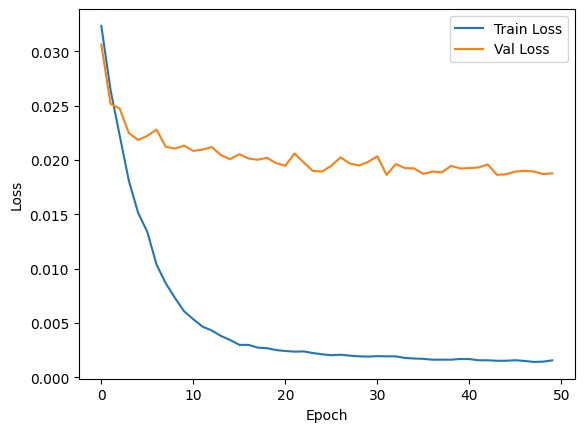

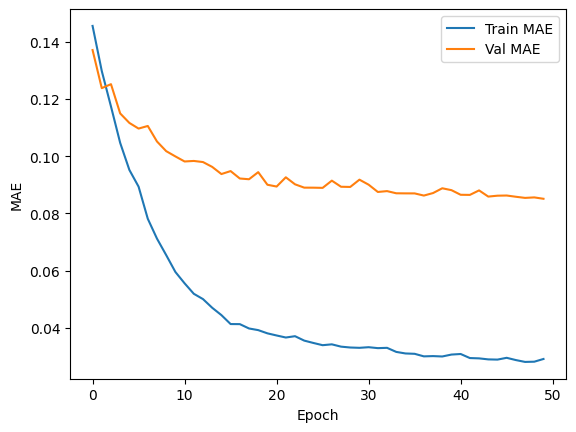

In [42]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [89]:
# Save the entire model
torch.save(model.state_dict(), r'C:\Users\milen\git\ppChem\PPChem_TLC\models\model.pt')

In [ ]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN(input_size=X_train.shape[1], dropout_prob=0.1)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_r2s = []
val_r2s = []

n_epochs = 70

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    # Compute R^2
    train_r2 = r2_score(y_train_tensor.detach().numpy(), model(X_train_tensor).detach().numpy())
    val_r2 = r2_score(y_val_tensor.detach().numpy(), model(X_val_tensor).detach().numpy())
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}, Train R^2: {train_r2}, Val R^2: {val_r2}')

# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot training and validation R^2
plt.subplot(1, 3, 3)
plt.plot(train_r2s, label='Train R^2')
plt.plot(val_r2s, label='Val R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.legend()

plt.tight_layout()
plt.show()

### Parameter Grid Search

In [121]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Initialize the model with Skorch
net = NeuralNetRegressor(
    FCNN,
    module__input_size=X_train.shape[1],
    module__dropout_prob=0.2,
    max_epochs=50,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Define the parameter grid
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'max_epochs': [20, 50, 100],
    'module__dropout_prob': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128]
}

# Create the grid search object
gs = GridSearchCV(net, param_grid, refit=True, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Perform the search
gs.fit(X_train.astype(np.float32), y_train.astype(np.float32))

# Get the best parameters and the corresponding score
print(f"Best parameters found: {gs.best_params_}")
print(f"Best cross-validation score: {-gs.best_score_}")

# Evaluate the best model on the validation set
best_model = gs.best_estimator_
val_predictions = best_model.predict(X_val.astype(np.float32))
val_loss = np.mean((val_predictions - y_val.astype(np.float32)) ** 2)
print(f"Validation Loss: {val_loss}")

# You can also plot training and validation losses if available
train_losses = best_model.history[:, 'train_loss']
valid_losses = best_model.history[:, 'valid_loss']

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# If you also have MAE recorded in the history, you can plot that as well
if 'train_mae' in best_model.history and 'valid_mae' in best_model.history:
    train_maes = best_model.history[:, 'train_mae']
    valid_maes = best_model.history[:, 'valid_mae']

    plt.plot(train_maes, label='Train MAE')
    plt.plot(valid_maes, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits


### Self attention

Epoch 1, Train Loss: 0.022604171657248547, Val Loss: 0.014227159088477492, Train MAE: 0.16585879953284013, Val MAE: 0.1369874949256579
Epoch 2, Train Loss: 0.014397767215575043, Val Loss: 0.012747492408379912, Train MAE: 0.13499888769890134, Val MAE: 0.12514653305212656
Epoch 3, Train Loss: 0.01145357243030479, Val Loss: 0.012440237992753586, Train MAE: 0.11897816148243452, Val MAE: 0.12181190835932891
Epoch 4, Train Loss: 0.009681904208111136, Val Loss: 0.01311415332990388, Train MAE: 0.10846612037796723, Val MAE: 0.12268376785020034
Epoch 5, Train Loss: 0.007425663865318424, Val Loss: 0.012478133973975977, Train MAE: 0.09437253788897866, Val MAE: 0.11990832599500816
Epoch 6, Train Loss: 0.005874656792730093, Val Loss: 0.010859568680947026, Train MAE: 0.08379052124525371, Val MAE: 0.10807306692004204
Epoch 7, Train Loss: 0.00435687710384005, Val Loss: 0.011146606489395102, Train MAE: 0.07112867447890733, Val MAE: 0.10802239055434863
Epoch 8, Train Loss: 0.0036957466876820512, Val Loss

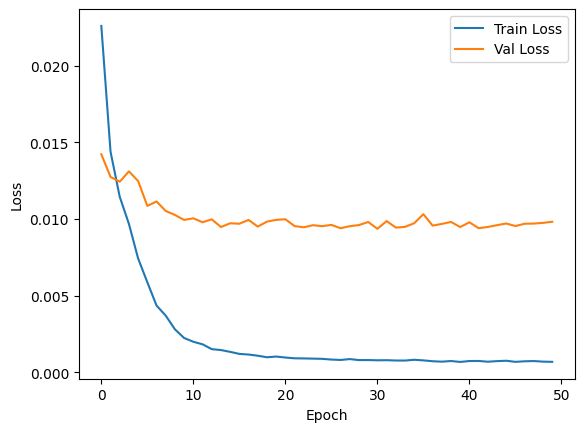

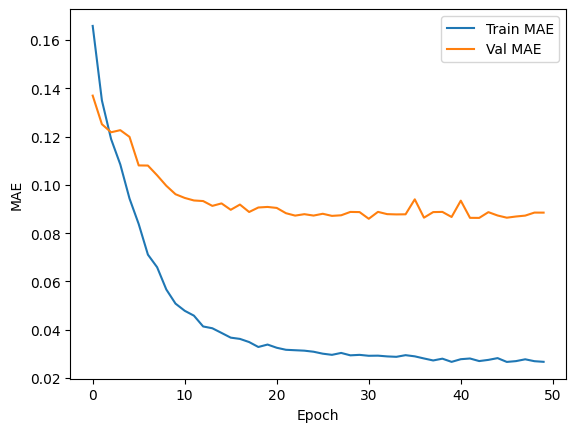

In [22]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN_att(input_size=X_train.shape[1], dropout_prob=0.2)
#loss_fn = nn.MSELoss()  # Mean Squared Error loss
loss_fn = nn.HuberLoss(delta=1.0)  # Huber loss
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Hyperparameter tuning for self attention

Epoch 1, Train Loss: 0.04573739286708205, Val Loss: 0.031875602745761476, Train MAE: 0.1691211843176892, Val MAE: 0.14547593394915262
Epoch 2, Train Loss: 0.033064293351612595, Val Loss: 0.03060930680173139, Train MAE: 0.14686618353191175, Val MAE: 0.14027462527155876
Epoch 3, Train Loss: 0.030353412875219397, Val Loss: 0.029159342171624303, Train MAE: 0.14045792755327727, Val MAE: 0.1398562751710415
Epoch 4, Train Loss: 0.02755032107234001, Val Loss: 0.025722428613031905, Train MAE: 0.13270961250129498, Val MAE: 0.1294085377206405
Epoch 5, Train Loss: 0.02471891523976075, Val Loss: 0.02439615735784173, Train MAE: 0.12510133338601967, Val MAE: 0.12410563758263986
Epoch 6, Train Loss: 0.022176059894263744, Val Loss: 0.023550297909726698, Train MAE: 0.1171825846559123, Val MAE: 0.12069059784213702
Epoch 7, Train Loss: 0.02007945558350337, Val Loss: 0.023062780654678743, Train MAE: 0.11090974360704423, Val MAE: 0.11834414582699537
Epoch 8, Train Loss: 0.01835564769020206, Val Loss: 0.0234

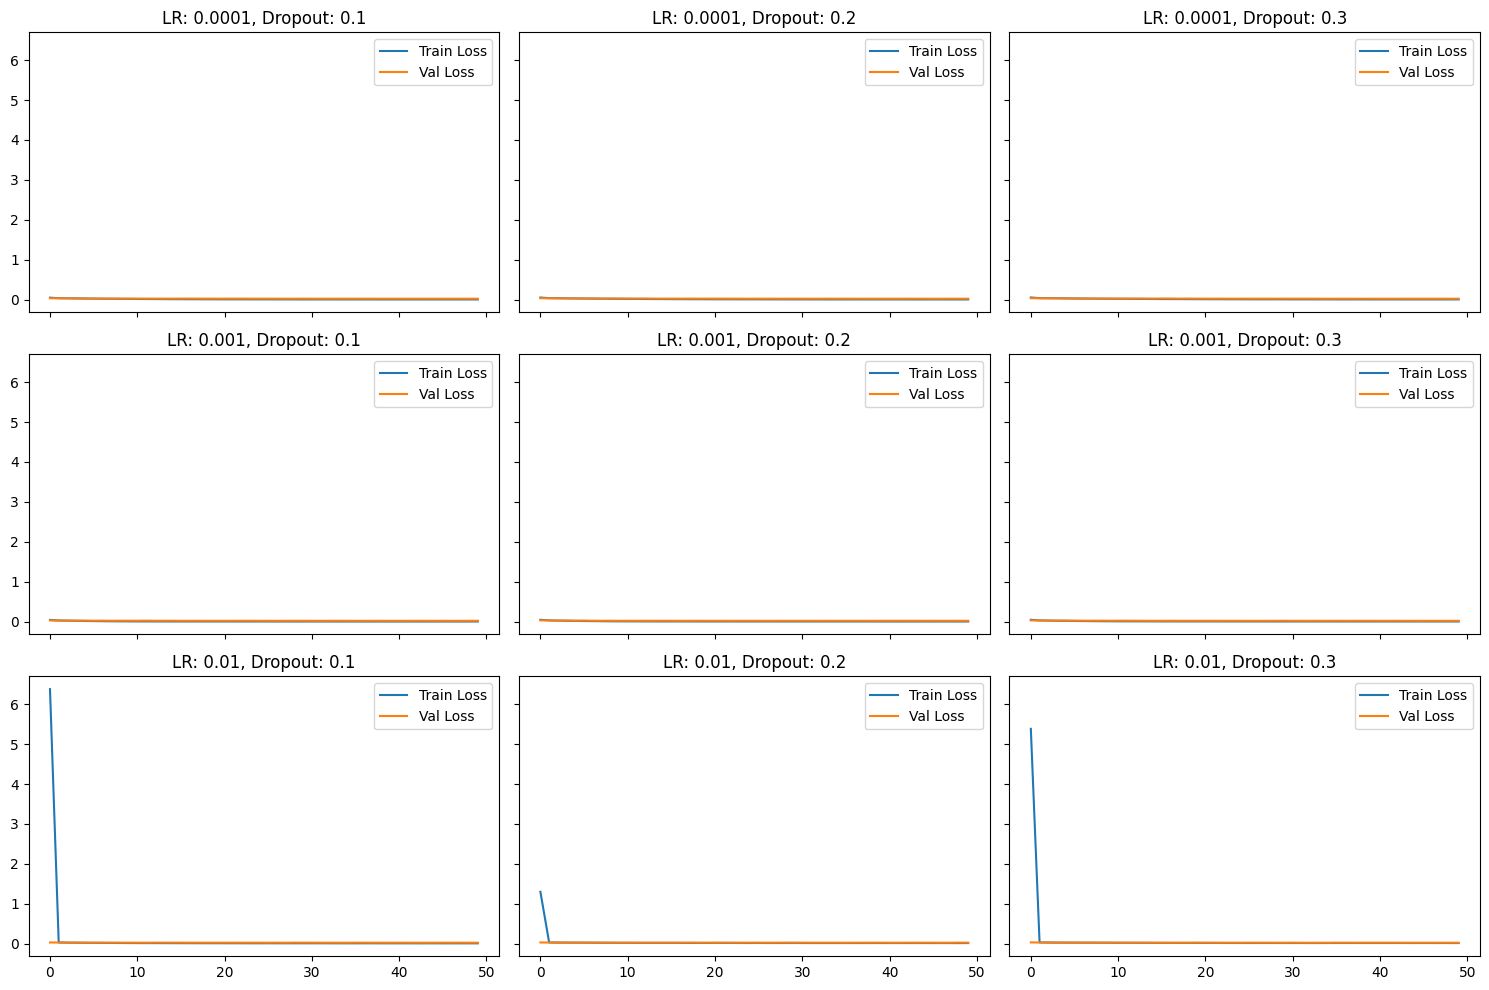

In [46]:
# Hyperparameters to tune
learning_rates = [1e-4, 1e-3, 1e-2]
dropout_probs = [0.1, 0.2, 0.3]
n_epochs = 50

best_val_loss = float('inf')
best_params = None
best_model = None

all_train_losses = {}
all_val_losses = {}

for lr in learning_rates:
    for dropout_prob in dropout_probs:
        model = FCNN_att(input_size=X_train.shape[1], dropout_prob=dropout_prob)
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_losses = []
        val_losses = []
        train_maes = []
        val_maes = []

        for epoch in range(n_epochs):
            train_mae = 0
            val_mae = 0
            model.train()
            train_loss = 0
            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                 # Compute MAE
                mae = torch.mean(torch.abs(outputs - labels))
                train_mae += mae.item()

            train_loss /= len(train_dataloader)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    # Compute MAE
                    mae = torch.mean(torch.abs(outputs - labels))
                    val_mae += mae.item()

            val_loss /= len(val_dataloader)
            val_losses.append(val_loss)
            train_maes.append(train_mae / len(train_dataloader))
            val_maes.append(val_mae / len(val_dataloader))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = (lr, dropout_prob)
                best_model = model.state_dict()

            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

        all_train_losses[(lr, dropout_prob)] = train_losses
        all_val_losses[(lr, dropout_prob)] = val_losses

print(f'Best params: LR: {best_params[0]}, Dropout: {best_params[1]}, Val Loss: {best_val_loss}')

# Load best model
if best_model:
    model.load_state_dict(best_model)

# Plot training and validation losses for each hyperparameter combination
fig, axes = plt.subplots(len(learning_rates), len(dropout_probs), figsize=(15, 10), sharex=True, sharey=True)

for i, lr in enumerate(learning_rates):
    for j, dropout_prob in enumerate(dropout_probs):
        ax = axes[i, j]
        ax.plot(all_train_losses[(lr, dropout_prob)], label='Train Loss')
        ax.plot(all_val_losses[(lr, dropout_prob)], label='Val Loss')
        ax.set_title(f'LR: {lr}, Dropout: {dropout_prob}')
        ax.legend()

plt.tight_layout()
plt.show()

### ChemBERTA

In [8]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "True"

In [9]:
df = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_cb = df.copy()
df_cb = df_cb[df_cb['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_cb['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [10]:
# Fill missing solvent SMILES with a placeholder (e.g., an empty string)
df_cb['Solvent_A_Smiles'] = df_cb['Solvent_A_Smiles'].fillna('')
df_cb['Solvent_B_Smiles'] = df_cb['Solvent_B_Smiles'].fillna('')

# Create binary indicators for solvent presence
df_cb.loc[:, 'Solvent_A_Present'] = df_cb['Solvent_A_Smiles'].apply(lambda x: 0 if x == '' else 1)
df_cb.loc[:, 'Solvent_B_Present'] = df_cb['Solvent_B_Smiles'].apply(lambda x: 0 if x == '' else 1)

# Extract relevant columns
product_smiles = df_cb['productSmiles_processed'].tolist()
solvent_a_smiles = df_cb['Solvent_A_Smiles'].tolist()
solvent_b_smiles = df_cb['Solvent_B_Smiles'].tolist()
percent_a = df_cb['Percent_A'].values
percent_b = df_cb['Percent_B'].values
solvent_a_present = df_cb['Solvent_A_Present'].values
solvent_b_present = df_cb['Solvent_B_Present'].values
rf_values = df_cb['Rf'].values

In [13]:
# Define the dataset class
class TLC_Dataset(Dataset):
    def __init__(self, product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels):
        self.product_smiles = product_smiles
        self.solvent_a_smiles = solvent_a_smiles
        self.solvent_b_smiles = solvent_b_smiles
        self.numerical_features = numerical_features
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        product_smiles = self.product_smiles[idx]
        solvent_a_smiles = self.solvent_a_smiles[idx]
        solvent_b_smiles = self.solvent_b_smiles[idx]
        numerical_features = self.numerical_features[idx]
        labels = self.labels[idx]
        return product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels

In [14]:
# Combine numerical features
numerical_features = torch.tensor(list(zip(percent_a, percent_b, solvent_a_present, solvent_b_present)), dtype=torch.float32)

# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(product_smiles)), test_size=0.2, random_state=42)

# Create training and validation datasets
train_dataset = TLC_Dataset(
    [product_smiles[i] for i in train_indices],
    [solvent_a_smiles[i] for i in train_indices],
    [solvent_b_smiles[i] for i in train_indices],
    numerical_features[train_indices],
    rf_values[train_indices]
)

val_dataset = TLC_Dataset(
    [product_smiles[i] for i in val_indices],
    [solvent_a_smiles[i] for i in val_indices],
    [solvent_b_smiles[i] for i in val_indices],
    numerical_features[val_indices],
    rf_values[val_indices]
)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [15]:
# Initialize the model, loss function, and optimizer
model = FCNNWithChemBERTa(dropout_prob=0.2)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0

    # Training loop
    model.train()
    for product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features)
        
        # Reshape the target tensor
        labels = labels.view(-1, 1)
            
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # Validation loop
    model.eval()
    with torch.no_grad():
        for product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels in val_dataloader:
            outputs = model(product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features)
            
            # Reshape the target tensor
            labels = labels.view(-1, 1)
            
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1, Train Loss: 0.03765287911029239, Val Loss: 0.03027833695523441
Epoch 2, Train Loss: 0.03057007685695824, Val Loss: 0.025522739471246798
Epoch 3, Train Loss: 0.02493317137031179, Val Loss: 0.023416260723024607
Epoch 4, Train Loss: 0.019186795944053876, Val Loss: 0.021959412066886824
Epoch 5, Train Loss: 0.01503247668672549, Val Loss: 0.022484306168432038
Epoch 6, Train Loss: 0.012363688971259092, Val Loss: 0.02227227626523624
Epoch 7, Train Loss: 0.011013200673225679, Val Loss: 0.02053161369015773
Epoch 8, Train Loss: 0.009127375919763979, Val Loss: 0.019613288653393585


KeyboardInterrupt: 

### FCNN with Rdkit descriptors

In [23]:
# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)

# concatenate all the 2D numpy arrays to a big 2D numpy array
descriptors = np.concatenate([compound_descriptors, solvent_A_descriptors, solvent_B_descriptors, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(descriptors.shape, type(descriptors), descriptors.ndim, y.ndim, y.shape)

(15062, 14) <class 'numpy.ndarray'> 2 2 (15062, 1)


In [24]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(descriptors, y, test_size=0.2, random_state=42)

Epoch 1, Train Loss: 3.2132589612352223, Val Loss: 0.05130237868676583, Train MAE: 0.6484775354987696, Val MAE: 0.17845184231797853
Epoch 2, Train Loss: 0.061187665399752164, Val Loss: 0.03543417054849366, Train MAE: 0.1919687420129776, Val MAE: 0.15149609620372453
Epoch 3, Train Loss: 0.04512547991777721, Val Loss: 0.03537416613350312, Train MAE: 0.16897919789740914, Val MAE: 0.1508212344100078
Epoch 4, Train Loss: 0.04146624850599389, Val Loss: 0.03661454034348329, Train MAE: 0.16226254105567933, Val MAE: 0.15203815884888172
Epoch 5, Train Loss: 0.03899119108131057, Val Loss: 0.03473312982047597, Train MAE: 0.1579721571583497, Val MAE: 0.14977127437790236
Epoch 6, Train Loss: 0.037879091952192155, Val Loss: 0.03399768207843105, Train MAE: 0.15623506684052316, Val MAE: 0.14856745364765325
Epoch 7, Train Loss: 0.03716555461287498, Val Loss: 0.03486862895078957, Train MAE: 0.15517710557109432, Val MAE: 0.14924875274300575
Epoch 8, Train Loss: 0.036427647483191994, Val Loss: 0.0433860511

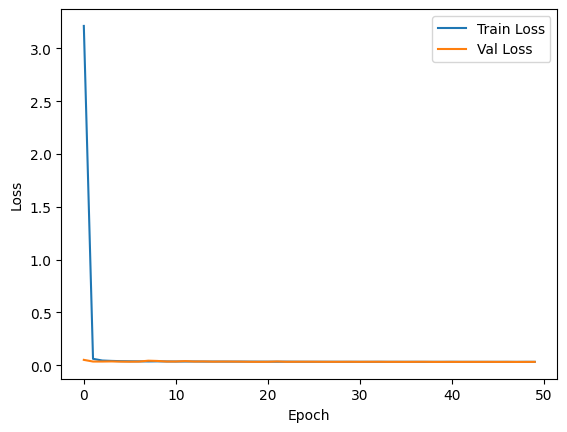

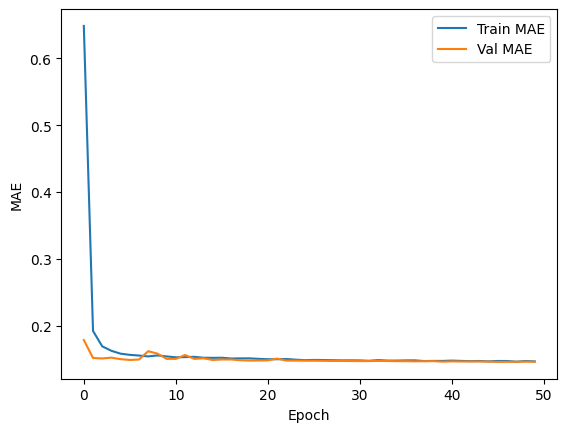

In [25]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN_att(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
#loss_fn = nn.HuberLoss(delta=1.0)  # Huber loss
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### FCNN with Morgan FPs and RDKit Descriptors

In [26]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
# percent A and B are already in the correct format

# concatenate all the 2D numpy arrays to a big 2D numpy array
features_2 = np.concatenate([compound_features, compound_descriptors, solvent_A_features, solvent_A_descriptors, solvent_B_features, solvent_B_descriptors, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(features_2.shape, type(features_2), features_2.ndim, y.ndim, y.shape)

(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2
(15062, 2574) <class 'numpy.ndarray'> 2 2 (15062, 1)


In [27]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(features_2, y, test_size=0.2, random_state=42)

# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

print(y_val_tensor)
# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Initialize the model, loss function, and optimizer
model = FCNN_att(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

tensor([[0.1800],
        [0.3200],
        [0.5100],
        ...,
        [0.3000],
        [0.5400],
        [0.5500]])
Epoch 1, Train Loss: 0.042196621920725715, Val Loss: 0.02987621591279381, Train MAE: 0.15859131483405592, Val MAE: 0.13829819716905292
Epoch 2, Train Loss: 0.0290047450890315, Val Loss: 0.027747915812620993, Train MAE: 0.13650820906266609, Val MAE: 0.1310581070812125
Epoch 3, Train Loss: 0.0265859851776684, Val Loss: 0.027052981749569115, Train MAE: 0.1305878435110856, Val MAE: 0.13029743793763612
Epoch 4, Train Loss: 0.02504358207436392, Val Loss: 0.024720617501359236, Train MAE: 0.12622653036835338, Val MAE: 0.12463940844724053
Epoch 5, Train Loss: 0.022806236105390506, Val Loss: 0.031166900762994037, Train MAE: 0.11965210891924107, Val MAE: 0.14521646350622178
Epoch 6, Train Loss: 0.02130080480869632, Val Loss: 0.024984621305606868, Train MAE: 0.11539571584061539, Val MAE: 0.12192691791998712
Epoch 7, Train Loss: 0.020370426901495108, Val Loss: 0.0277564988814686

KeyboardInterrupt: 

# Transfer Learning with ChemBERTa Embeddings

In [46]:
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [49]:


# Load pre-trained ChemBERTa model and tokenizer
chemberta_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Function to extract ChemBERTa embeddings
def extract_embeddings(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = chemberta_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    mean_embeddings = last_hidden_states.mean(dim=1).numpy()  # Average pooling over tokens
    return mean_embeddings

def safe_extract_embeddings(x):
    if x is None or not isinstance(x, str):
        # Return a numpy array of zeros with the same dimension as the embeddings
        return np.zeros((1, 768))
    else:
        return extract_embeddings(x)

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [55]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_fp['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [48]:
df['productSmiles_processed'] = df['productSmiles_processed'].astype(str)
print(type(df_fp['productSmiles_processed']), df_fp['productSmiles_processed'][0])

<class 'pandas.core.series.Series'> CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1


In [56]:
# apply fingerprint and descriptor generation function
df_fp = create_fingerprints(df_fp, 'productSmiles_processed')
df_fp = create_fingerprints(df_fp, 'Solvent_A_Smiles')
df_fp = create_fingerprints(df_fp, 'Solvent_B_Smiles')

# Extract ChemBERTa embeddings for product smiles
df_fp['product_embeddings'] = df_fp['productSmiles_processed'].apply(safe_extract_embeddings)
compound_embeddings = np.stack(df_fp['product_embeddings'].values)

# Apply mean pooling across the token dimension
compound_embeddings = np.mean(compound_embeddings, axis=1)

# compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)

# convert the percent values to numpy arrays
df_fp['Percent_A'] = df_fp['Percent_A'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
df_fp['Percent_B'] = df_fp['Percent_B'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))

# Stack the percent values to numpy arrays
percent_a = np.stack(df_fp['Percent_A'].values)
percent_b = np.stack(df_fp['Percent_B'].values)

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# Concatenate all arrays into a single feature matrix
X = np.concatenate([compound_embeddings, solvent_A_descriptors, solvent_B_descriptors, percent_a, percent_b], axis=1)

y = np.stack(df_fp['Rf'].values)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [57]:
# Save the embeddings and other preprocessed data
np.savez_compressed('preprocessed_data.npz', 
                    X_train_chemberta=X_train, y_train_chemberta=y_train, 
                    X_val_chemberta=X_val, y_val_chemberta=y_val, 
                    X_test_chemberta=X_test, y_test_chemberta=y_test)

In [44]:
data = np.load('preprocessed_data.npz')

X_train = data['X_train_chemberta']
y_train = data['y_train_chemberta']
X_val = data['X_val_chemberta']
y_val = data['y_val_chemberta']
X_test = data['X_test_chemberta']
y_test = data['y_test_chemberta']

In [16]:
# Function to get metrics
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

def get_metrics(X_, y_, model, option='Train'):
    # Get predictions
    y_pred = model.predict(X_)
    
    # Calculate Mean Squared Error
    mse = np.round(mean_squared_error(y_, y_pred), 4)
    print(f"{option} Mean Squared Error:", mse)

    # Calculate Spearman Correlation
    spearman_corr, _ = np.round(spearmanr(y_, y_pred), 4)
    print(f"{option} Spearman Correlation:", spearman_corr)
    
    # Calculate R^2 score
    r2 = np.round(r2_score(y_, y_pred), 4)
    print(f"{option} R^2:", r2)
    

### XGBoost

Train Mean Squared Error: 0.0329
Train Spearman Correlation: 0.3234
Validation Mean Squared Error: 0.0332
Validation Spearman Correlation: 0.2567


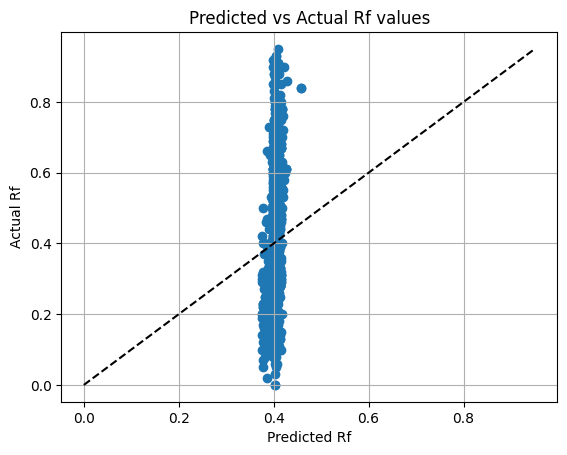

In [59]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# Define XGBoost regressor parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.9,
    'learning_rate': 0.001,
    'max_depth': 4,
    'n_estimators': 200,
    'subsample': 0.8,
    'random_state': 42
}

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(**xgb_params)

# Train the XGBoost regressor
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, xgb_model, option='Train')
get_metrics(X_val, y_val, xgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = xgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

In [45]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0]
}

# Create a base model
xgb_model = xgb.XGBRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Train and evaluate the model with the best parameters
xgb_model_best = xgb.XGBRegressor(**best_params)
xgb_model_best.fit(X_train, y_train)

get_metrics(X_train, y_train, xgb_model_best, option='Train')
get_metrics(X_val, y_val, xgb_model_best, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = xgb_model_best.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values for Best Model')
plt.grid()
plt.show()

NameError: name 'xgb' is not defined

### LightGBM

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196021
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 778


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Start training from score 0.403139
Train Mean Squared Error: 0.0002
Train Spearman Correlation: 0.9964
Train R^2: 0.9937
Validation Mean Squared Error: 0.0179
Validation Spearman Correlation: 0.6772
Validation R^2: 0.4703


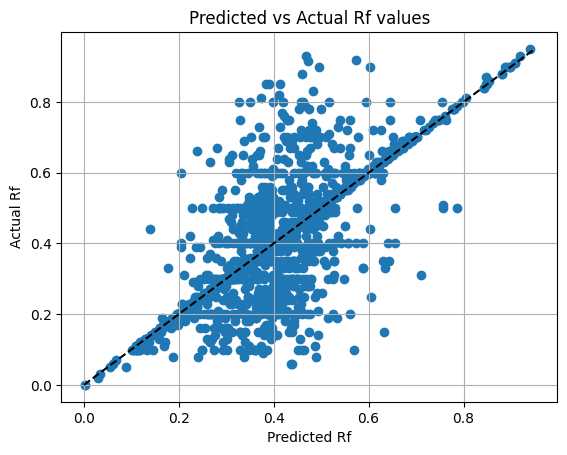

In [19]:
# Light GBM
import lightgbm as lgb
# Define LightGBM regressor parameters
lgb_params = {
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'random_state': 1,
    'n_jobs': 1
}

# Create a LightGBM regressor
lgb_model = lgb.LGBMRegressor(**lgb_params)

# Train the LightGBM regressor
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [500, 1000, 2000],
}

# Create a LightGBM regressor
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=1, n_jobs=1)

# Create the grid search object
grid = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid.best_params_)

# Train the LightGBM regressor with the best parameters
lgb_model = lgb.LGBMRegressor(**grid.best_params_, objective='regression', random_state=1, n_jobs=1)
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

### FCNN on chemberta

Epoch 1, Train Loss: 0.034086315353450025, Val Loss: 0.032966619823127985, Train MAE: 0.14991972258216457, Val MAE: 0.14769289766748747
Epoch 2, Train Loss: 0.0323309278409732, Val Loss: 0.03289243609954914, Train MAE: 0.14545709875069165, Val MAE: 0.1498268097639084
Epoch 3, Train Loss: 0.031632686053451736, Val Loss: 0.03212116829430064, Train MAE: 0.1438479643119009, Val MAE: 0.14510921637217203
Epoch 4, Train Loss: 0.031128462305978724, Val Loss: 0.03180248336866498, Train MAE: 0.14282328023722296, Val MAE: 0.14589476337035498
Epoch 5, Train Loss: 0.030293026958641254, Val Loss: 0.032316306295494236, Train MAE: 0.1402760511166171, Val MAE: 0.14814557631810507
Epoch 6, Train Loss: 0.030393733103808603, Val Loss: 0.031102684947351616, Train MAE: 0.1406047989663325, Val MAE: 0.1422461705903212
Epoch 7, Train Loss: 0.029478999364532923, Val Loss: 0.03187382764493426, Train MAE: 0.13791310026457435, Val MAE: 0.14705264444152513
Epoch 8, Train Loss: 0.02877809775895194, Val Loss: 0.03064

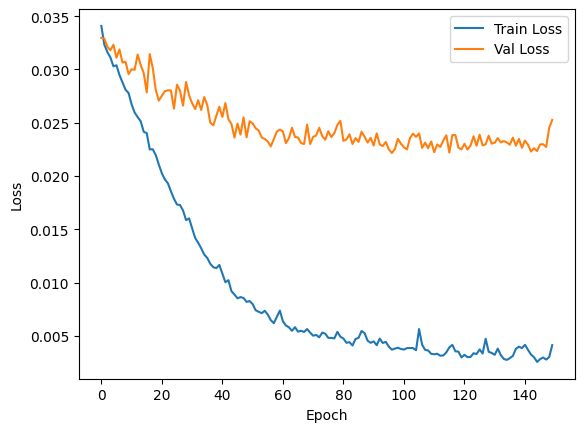

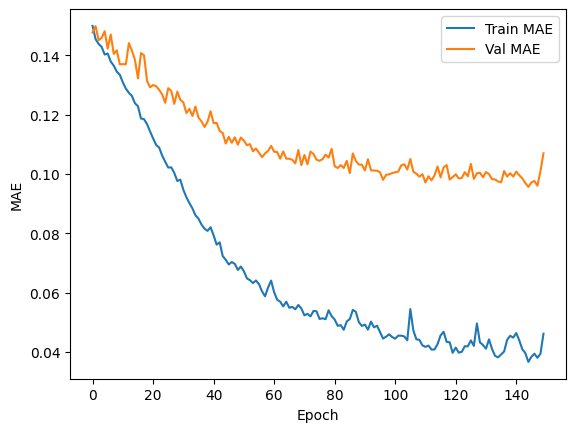

In [13]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN_deep(input_size=X_train.shape[1], dropout_prob=0.0)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 150

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Gradient Boosting Regressor

In [61]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to the data
gb_model.fit(X_train, y_train)

# Get metrics
get_metrics(X_train, y_train, gb_model, option='Train')
get_metrics(X_val, y_val, gb_model, option='Validation')
#get_metrics(X_test, y_test, gb_model, option='Test')

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Train Mean Squared Error: 0.0249
Train Spearman Correlation: 0.5599
Validation Mean Squared Error: 0.0284
Validation Spearman Correlation: 0.4123


### Random Forest Regressor

In [62]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the data
rf_model.fit(X_train, y_train)

# Get metrics
get_metrics(X_train, y_train, rf_model, option='Train')
get_metrics(X_val, y_val, rf_model, option='Validation')
#get_metrics(X_test, y_test, rf_model, option='Test')

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train Mean Squared Error: 0.0025
Train Spearman Correlation: 0.9832
Validation Mean Squared Error: 0.0179
Validation Spearman Correlation: 0.6865


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rf_model = RandomForestRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Train and evaluate the model with the best parameters
rf_model_best = RandomForestRegressor(**best_params)
rf_model_best.fit(X_train, y_train)

get_metrics(X_train, y_train, rf_model_best, option='Train')
get_metrics(X_val, y_val, rf_model_best, option='Validation')

Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

# FCNN with embedded NN

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [115]:
# Encoder for dimensionality reduction
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

# Define the Combined Network class (encoder + decoder)
class CombinedNet(nn.Module):
    def __init__(self, compound_input_dim, solvent_input_dim, embedding_dim, dropout_prob):
        super(CombinedNet, self).__init__()
        self.compound_encoder = Encoder(compound_input_dim, embedding_dim)
        self.solvent_encoder = Encoder(solvent_input_dim, embedding_dim)

        # The input dimension to the final network is the concatenated embeddings + 2 percentages
        combined_input_dim = 3 * embedding_dim + 2

        self.fc1 = nn.Linear(combined_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, compound_fp, solvent_a_fp, solvent_b_fp, percent_a_tensor, percent_b_tensor):
        compound_embedding = self.compound_encoder(compound_fp)
        solvent_a_embedding = self.solvent_encoder(solvent_a_fp)
        solvent_b_embedding = self.solvent_encoder(solvent_b_fp)

        # Concatenate embeddings with percentages
        combined = torch.cat((compound_embedding, solvent_a_embedding, solvent_b_embedding, percent_a_tensor, percent_b_tensor), dim=1)

        x = self.relu(self.fc1(combined))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.sigmoid(self.fc4(x))
        return x

In [116]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

y = np.stack(df_fp['Rf'].values) # I don't know why I called this y, sorry man :D just out of habit I guess. 

(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2


In [117]:
#Split dataset
X_train_compound, X_test_compound, X_train_solvent_A, X_test_solvent_A, X_train_solvent_B, X_test_solvent_B, X_train_percent_a, X_test_percent_a, X_train_percent_b, X_test_percent_b, y_train, y_test = train_test_split(
compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features, y, test_size=0.2, random_state=42)

In [118]:
# Convert numpy arrays to PyTorch tensors
X_train_compound_tensor = torch.from_numpy(X_train_compound).float()
X_train_solvent_A_tensor = torch.from_numpy(X_train_solvent_A).float()
X_train_solvent_B_tensor = torch.from_numpy(X_train_solvent_B).float()
X_train_percent_a_tensor = torch.from_numpy(X_train_percent_a).float()
X_train_percent_b_tensor = torch.from_numpy(X_train_percent_b).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_compound_tensor = torch.from_numpy(X_test_compound).float()
X_test_solvent_A_tensor = torch.from_numpy(X_test_solvent_A).float()
X_test_solvent_B_tensor = torch.from_numpy(X_test_solvent_B).float()
X_test_percent_a_tensor = torch.from_numpy(X_test_percent_a).float()
X_test_percent_b_tensor = torch.from_numpy(X_test_percent_b).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor, y_test_tensor)

# Create DataLoaders, define batch size
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 1, Train Loss: 0.03168932345533182, Val Loss: 0.025639007333666086, Train MAE: 0.1435253666270347, Val MAE: 0.1278452519327402
Epoch 2, Train Loss: 0.022429949042224694, Val Loss: 0.023209139646496624, Train MAE: 0.1169935512558493, Val MAE: 0.11747780147319038
Epoch 3, Train Loss: 0.01272776064083532, Val Loss: 0.01896004764906441, Train MAE: 0.08471860811508522, Val MAE: 0.09997888701036572
Epoch 4, Train Loss: 0.006965658872600191, Val Loss: 0.01892938625921185, Train MAE: 0.061577881612474954, Val MAE: 0.09463534511936207
Epoch 5, Train Loss: 0.004374703629528759, Val Loss: 0.018004423143186916, Train MAE: 0.0483939327082779, Val MAE: 0.09070129630466302
Epoch 6, Train Loss: 0.0031931475759607066, Val Loss: 0.017102680227253586, Train MAE: 0.04098549134359158, Val MAE: 0.08979107455040018
Epoch 7, Train Loss: 0.0025462705411618113, Val Loss: 0.017643270703653496, Train MAE: 0.03633963309780315, Val MAE: 0.09125830543537934
Epoch 8, Train Loss: 0.0022666253717419094, Val Loss:

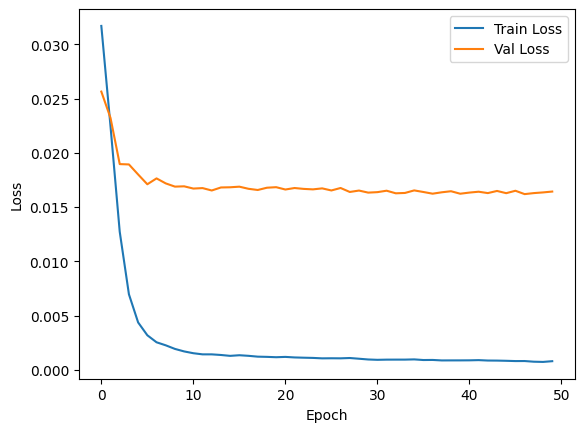

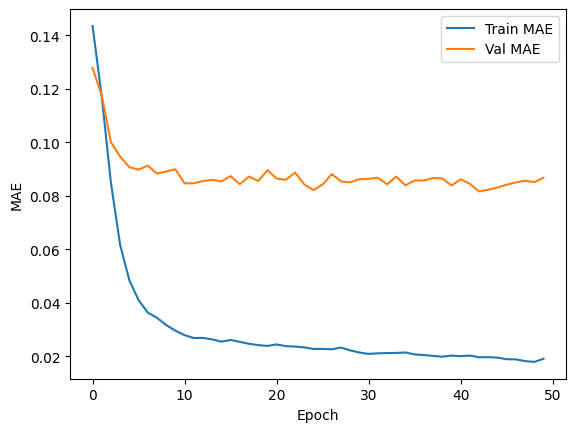

In [119]:
# Initialize the model, loss function, and optimizer
model = CombinedNet(compound_input_dim=2048, solvent_input_dim=256, embedding_dim=128, dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor, y_train_tensor in train_dataloader:
        optimizer.zero_grad()
        outputs = model(X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - y_train_tensor))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor, y_test_tensor in val_dataloader:
            outputs = model(X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor)
            loss = loss_fn(outputs, y_test_tensor)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - y_test_tensor))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# MACCS + solvent feature

In [24]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys

df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]

# Convert SMILES to MACCS fingerprints
df_fp['MACCS'] = df_fp['productSmiles_processed'].apply(lambda x: MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)))

# List of solvents
solvents = ['DCM', 'MeOH', 'MeCN', 'Toluene', 'Hexane', 'Chloroform', 'Acetone', 'EtOH', 'diethyl ether', 'heptane', 'petroleum ether (2-methylpentane)', 'triethylamine', 'EtOAc', 'THF']

# Create a new column for the solvent features
df_fp['solvent_feature'] = [[] for _ in range(len(df_fp))]

for index, row in df_fp.iterrows():
    solvent_feature = np.zeros(len(solvents))
    
    # Check solvent_A
    solvent_A = row['Solvent_A']
    if solvent_A in solvents:
        solvent_A_index = solvents.index(solvent_A)
        solvent_feature[solvent_A_index] = row['Percent_A']
        
        # If Percent_A is 100, there won't be a solvent_B
        if row['Percent_A'] == 100:
            df_fp.at[index, 'solvent_feature'] = solvent_feature.tolist()
            continue
    
    # Check solvent_B
    solvent_B = row['Solvent_B']
    if solvent_B in solvents:
        solvent_B_index = solvents.index(solvent_B)
        solvent_feature[solvent_B_index] = row['Percent_B']
        
    df_fp.at[index, 'solvent_feature'] = solvent_feature.tolist()

df_fp = create_fingerprints(df_fp, 'productSmiles_processed')

df_fp.head()

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,...,Percent_C,sum,Solvent_A_Smiles,Solvent_B_Smiles,extracted_pr_Smiles,productSmiles_processed,MACCS,solvent_feature,productSmiles_processed_Morgan_Fingerprint_np,productSmiles_processed_RDKit_Descriptors
0,2,A solution of 4-{[(phenylmethoxy)carbonylamino...,[C:1]1([CH2:7][O:8][C:9]([NH:11][CH2:12][C:13]...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],Preparation of N-methoxy-N-methyl(4-{[(phenylm...,0.3,petroleum ether (2-methylpentane),EtOAc,50.0,50.0,...,NaN,100.0,CCCC(C)C,O=C(OCC)C,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[328.36799999999994, 2.7464000000000013, 1.0, ..."
1,3,Putative nitrilase up-mutants were assayed in ...,[CH3:1][C:2]1(C)S[C@@H]2[C@H](NC([C@H](N)C3C=C...,['N#CC[C@@H](O)CC(=O)O'],NaN,0.5,EtOAc,Hexane,50.0,50.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['N#CC[C@@H](O)CC(=O)O'],N#CC[C@@H](O)CC(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[129.115, -0.26431999999999994, 2.0, 3.0]"
2,5,To 0.4 g N6-benzoyl-3′-O-(methylthiomethyl)-5′...,[C:1]([NH:9][C:10]1[C:11]2[N:12]=[CH:13][N:14]...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,NaN,0.3,EtOAc,Hexane,70.0,30.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cccc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[410.3940000000001, 2.0114000000000005, 2.0, 9.0]"
3,6,3.5 g N4-benzoyl-5′-O-tert-butyldimethylsilyl-...,[C:1]([NH:9][C:10]1[CH:30]=[CH:29][N:13]([C@@H...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,NaN,0.4,EtOAc,Hexane,90.0,10.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)O[...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[505.7130000000003, 4.510600000000005, 1.0, 8.0]"
4,7,To 0.5580 g N4-benzoyl-3′-O-(methylthiomethyl)...,[C:1]([NH:9][C:10]1[CH:33]=[CH:32][N:13]([C@@H...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,NaN,0.5,EtOAc,Hexane,5.0,95.0,...,NaN,100.0,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 95.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[386.36800000000017, 1.4283999999999997, 2.0, ..."


In [25]:
maccs = np.stack(df_fp['MACCS'].apply(lambda x: np.array(x)).values)
rdk_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].apply(lambda x: np.array(x)).values)
solvent_features_matr = np.stack(df_fp['solvent_feature'].values)

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# Concatenate all arrays into a single feature matrix
X = np.concatenate([maccs, rdk_descriptors, solvent_features_matr], axis=1)

y = np.stack(df_fp['Rf'].values)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [26]:
# Save the datasets
np.save('maccs_X_train.npy', X_train)
np.save('maccs_X_val.npy', X_val)
np.save('maccs_X_test.npy', X_test)
np.save('maccs_y_train.npy', y_train)
np.save('maccs_y_val.npy', y_val)
np.save('maccs_y_test.npy', y_test)

In [ ]:
# Load the datasets
X_train = np.load('maccs_X_train.npy')
X_val = np.load('maccs_X_val.npy')
X_test = np.load('maccs_X_test.npy')
y_train = np.load('maccs_y_train.npy')
y_val = np.load('maccs_y_val.npy')
y_test = np.load('maccs_y_test.npy')

## Light Gradient Boosting Model

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139
Train Mean Squared Error: 0.0024
Train Spearman Correlation: 0.9698
Train R^2: 0.929
Validation Mean Squared Error: 0.0159
Validation Spearman Correlation: 0.7211
Validation R^2: 0.5304


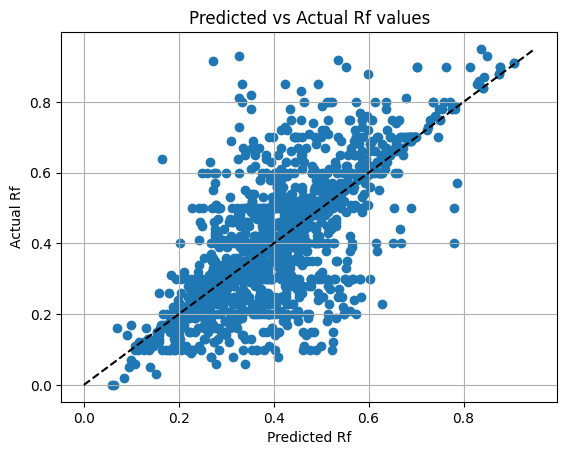

In [27]:
# Light GBM

import lightgbm as lgb
# Define LightGBM regressor parameters
lgb_params = {
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'random_state': 1,
    'n_jobs': 1
}

# Create a LightGBM regressor
lgb_model = lgb.LGBMRegressor(**lgb_params)

# Train the LightGBM regressor
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 168
[LightGBM] [Info] Start training from score 0.402448


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.404680


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.402079


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 9639, number of used features: 167
[LightGBM] [Info] Start training from score 0.403750


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 9640, number of used features: 168
[LightGBM] [Info] Start training from score 0.402738


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139
Best parameters found:  {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 100}


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 12049, number of used features: 168
[LightGBM] [Info] Start training from score 0.403139


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


Train Mean Squared Error: 0.0009
Train Spearman Correlation: 0.9881
Train R^2: 0.9734
Validation Mean Squared Error: 0.0149
Validation Spearman Correlation: 0.742
Validation R^2: 0.5595


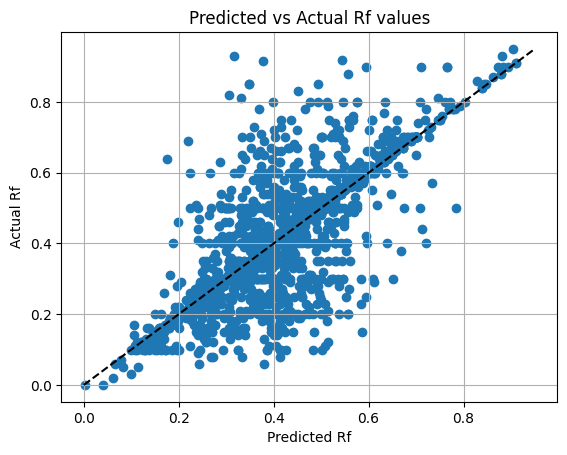

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [500, 1000, 2000],
}

# Create a LightGBM regressor
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=1, n_jobs=1)

# Create the grid search object
grid = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid.best_params_) #Best parameters found:  {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 100}, R^2 = 0.55

# Train the LightGBM regressor with the best parameters
lgb_model = lgb.LGBMRegressor(**grid.best_params_, objective='regression', random_state=1, n_jobs=1)
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Get metrics for train, validation, and test sets
get_metrics(X_train, y_train, lgb_model, option='Train')
get_metrics(X_val, y_val, lgb_model, option='Validation')

# Scatterplot of predicted vs. actual values 
pred = lgb_model.predict(X_test)
actual = y_test

plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted Rf')
plt.ylabel('Actual Rf')
plt.title('Predicted vs Actual Rf values')
plt.grid()
plt.show()

## FCNN

Epoch 1, Train Loss: 0.26469689439001837, Val Loss: 0.03839720692485571, Train MAE: 0.2768584053767355, Val MAE: 0.15380171810587248, Train R^2: -0.1513781628110744, Val R^2: -0.1339926298385692
Epoch 2, Train Loss: 0.038457959792331645, Val Loss: 0.0363127381230394, Train MAE: 0.1571539209077233, Val MAE: 0.15010561173160872, Train R^2: -0.09361203875723767, Val R^2: -0.07236013664526952
Epoch 3, Train Loss: 0.035036340669581764, Val Loss: 0.032020429304490484, Train MAE: 0.15083751051049482, Val MAE: 0.1439492218196392, Train R^2: 0.05409094122757119, Val R^2: 0.05387480294256286
Epoch 4, Train Loss: 0.034380340733026205, Val Loss: 0.04281255385528008, Train MAE: 0.14979870805614873, Val MAE: 0.15930522233247757, Train R^2: -0.310622422649385, Val R^2: -0.264403015069558
Epoch 5, Train Loss: 0.033082704226437366, Val Loss: 0.031029928475618362, Train MAE: 0.14575538815636385, Val MAE: 0.1419799104332924, Train R^2: 0.08152579202330501, Val R^2: 0.0831196497042116
Epoch 6, Train Loss:

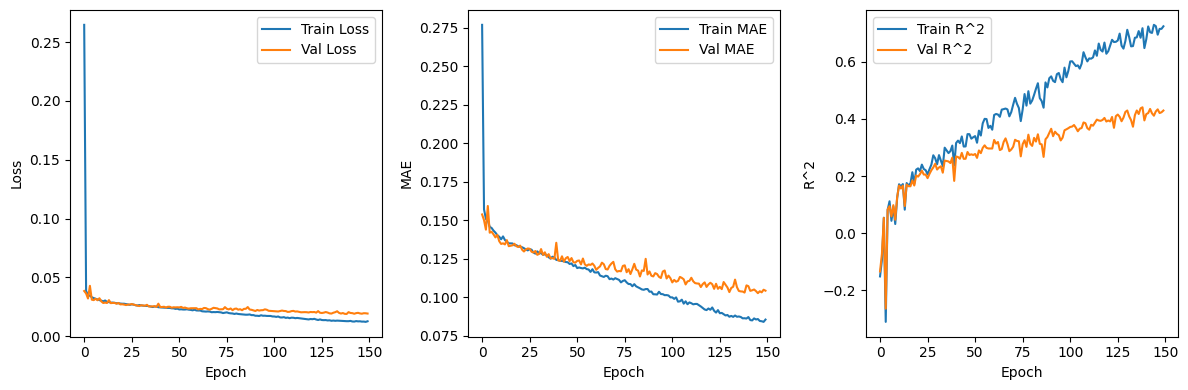

In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN_att(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_r2s = []
val_r2s = []

n_epochs = 150

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    # Compute R^2
    train_r2 = r2_score(y_train_tensor.detach().numpy(), model(X_train_tensor).detach().numpy())
    val_r2 = r2_score(y_val_tensor.detach().numpy(), model(X_val_tensor).detach().numpy())
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}, Train R^2: {train_r2}, Val R^2: {val_r2}')

# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot training and validation R^2
plt.subplot(1, 3, 3)
plt.plot(train_r2s, label='Train R^2')
plt.plot(val_r2s, label='Val R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.legend()

plt.tight_layout()
plt.show()

## Random Forest

Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


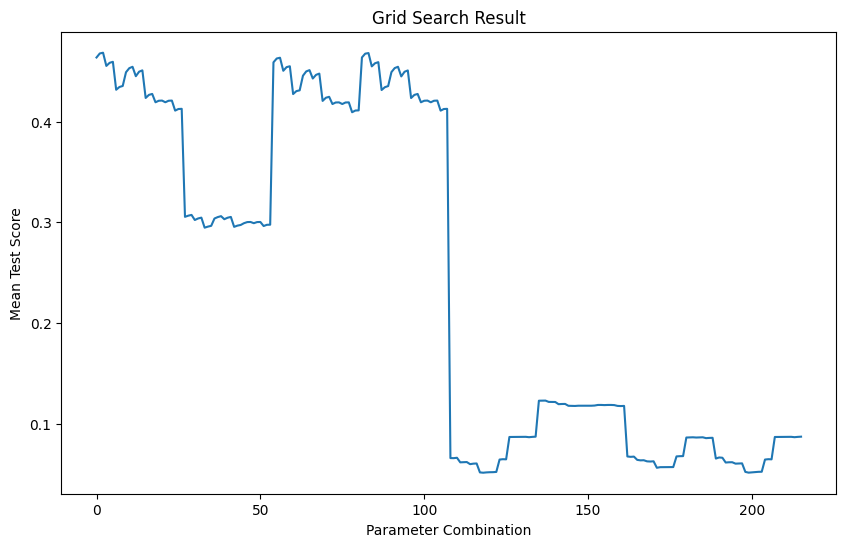

Best parameters:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


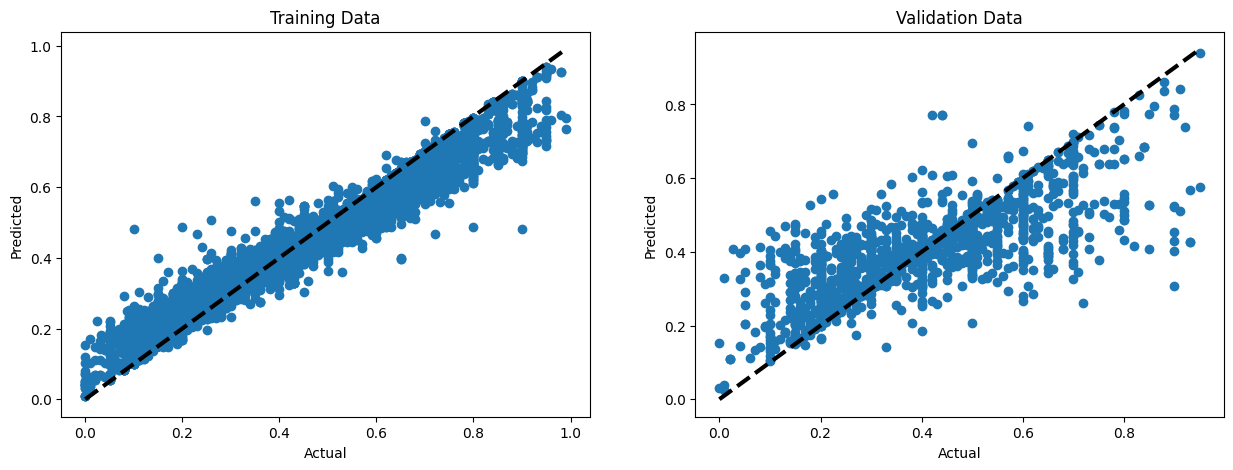

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the mean test scores
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Create a line plot of mean test scores
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_test_scores)), mean_test_scores)
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Result')
plt.show()

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Train and evaluate the model with the best parameters
rf_model_best = RandomForestRegressor(**best_params)
rf_model_best.fit(X_train, y_train)

# Predict the values
y_train_pred = rf_model_best.predict(X_train)
y_val_pred = rf_model_best.predict(X_val)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot for training data
axs[0].scatter(y_train, y_train_pred)
axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Training Data')

# Scatter plot for validation data
axs[1].scatter(y_val, y_val_pred)
axs[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=3)
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('Predicted')
axs[1].set_title('Validation Data')

# Show the plot
plt.show()

# Ensemble method

In [ ]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

# Define the base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=1000, random_state=1, n_jobs=1)),
    ('nn', MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, random_state=42))
]

# Define the meta model
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the stacking ensemble
stacking_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train.ravel())

# Make predictions
y_pred = stacking_ensemble.predict(X_test)

## 5.3 RandomForestRegression Model

Import packages for RandomForest Regressor

In [6]:
from sklearn.ensemble import RandomForestRegressor

Preprocess again all the data into a feature matrix (just wanted to try it with another stacking method here)

In [7]:
# Combine all features into a single 2D numpy array
X = np.hstack([
    np.vstack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Percent_A'].values),
    np.vstack(df_fp['Percent_B'].values)
])

y = np.vstack(df_fp['Rf'].values).flatten()  # Flatten to get a 1D array

In [8]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest - Mean Squared Error: 0.015674800020763036
Random Forest - R^2 Score: 0.5332279430548992


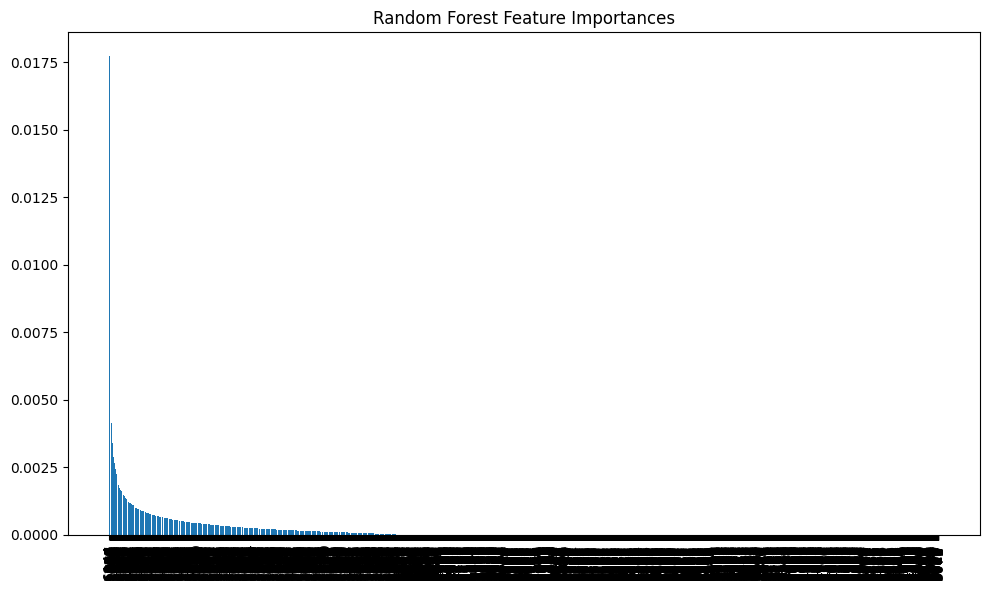

In [9]:
# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

# Feature importance plot
feature_importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), feature_importances_rf[indices_rf], align="center")
plt.xticks(range(X.shape[1]), indices_rf, rotation=90)
plt.tight_layout()
plt.show()

## 5.5 GradientBoostingRegressor Model - XGBoost

In [15]:
import xgboost as xgb
import optuna

Use same pre-processing as before.

In [11]:
# Combine all features into a single feature matrix
X = np.hstack([
    np.vstack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Percent_A'].values),
    np.vstack(df_fp['Percent_B'].values)
])

# Prepare the target variable
y = np.vstack(df_fp['Rf'].values).flatten()

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# use optuna for hyperparameter tuning
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1e-1),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.18191
[1]	validation_0-rmse:0.18076
[2]	validation_0-rmse:0.17948
[3]	validation_0-rmse:0.17865
[4]	validation_0-rmse:0.17759
[5]	validation_0-rmse:0.17688
[6]	validation_0-rmse:0.17607
[7]	validation_0-rmse:0.17530
[8]	validation_0-rmse:0.17471
[9]	validation_0-rmse:0.17412
[10]	validation_0-rmse:0.17357
[11]	validation_0-rmse:0.17321
[12]	validation_0-rmse:0.17268
[13]	validation_0-rmse:0.17202
[14]	validation_0-rmse:0.17149
[15]	validation_0-rmse:0.17098
[16]	validation_0-rmse:0.17073
[17]	validation_0-rmse:0.17042
[18]	validation_0-rmse:0.17003
[19]	validation_0-rmse:0.16966
[20]	validation_0-rmse:0.16929
[21]	validation_0-rmse:0.16903
[22]	validation_0-rmse:0.16872
[23]	validation_0-rmse:0.16841
[24]	validation_0-rmse:0.16800
[25]	validation_0-rmse:0.16773
[26]	validation_0-rmse:0.16748
[27]	validation_0-rmse:0.16723
[28]	validation_0-rmse:0.16702
[29]	validation_0-rmse:0.16691
[30]	validation_0-rmse:0.16670
[31]	validation_0-rmse:0.16644
[32]	validation_0-

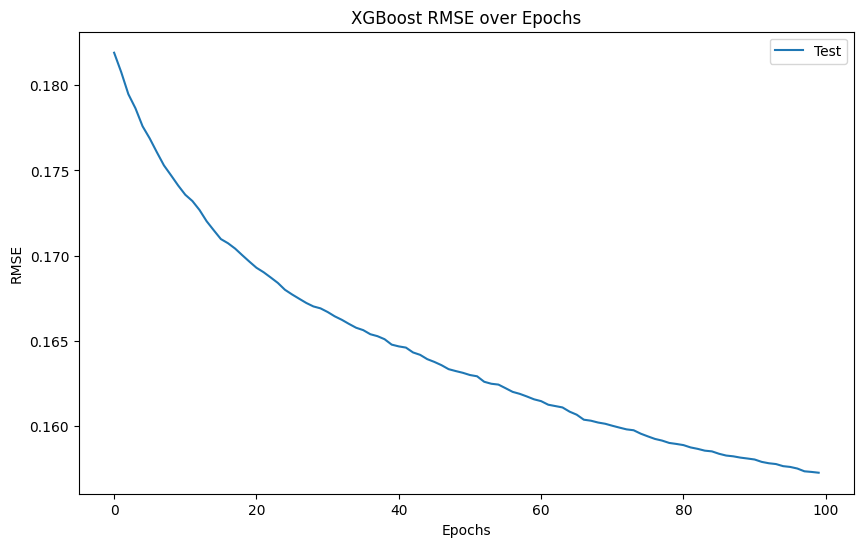

In [13]:
# XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Evaluate the XGBoost model
y_pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

# Plotting the evaluation results
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Epochs')
plt.legend()
plt.show()

In [18]:
# XGBoost Regressor with Optuna hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print(f"Best hyperparameters: {study.best_params}")

# Train the model with the best hyperparameters
best_params = study.best_params
model_xgb = xgb.XGBRegressor(**best_params)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Evaluate the model
y_pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

# Plotting the evaluation results
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Epochs')
plt.legend()
plt.show()

[I 2024-05-15 10:07:20,555] A new study created in memory with name: no-name-83025231-d2ca-4042-9667-115e8d79978f
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

KeyboardInterrupt: 

## 5.4 Ensemble Learning

### Stacking

In [45]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Initialize base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
]

# Train base models
train_meta_features = np.zeros((X_train.shape[0], len(base_models)))
test_meta_features = np.zeros((X_test.shape[0], len(base_models)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (name, model) in enumerate(base_models):
    for train_index, val_index in kf.split(X_train):
        model.fit(X_train[train_index], y_train[train_index])
        train_meta_features[val_index, i] = model.predict(X_train[val_index])
    model.fit(X_train, y_train)
    test_meta_features[:, i] = model.predict(X_test)

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(train_meta_features, y_train)

# Predict and evaluate
y_pred = meta_model.predict(test_meta_features)
mse = mean_squared_error(y_test, y_pred)
print(f"Stacking - Mean Squared Error: {mse}")

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

### Bagging
(Boostrap Aggregating = training multiple models on different subsets of the data and averaging the predictions)

In [ ]:
from sklearn.ensemble import BaggingRegressor

model_bagging = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=10, random_state=42)
model_bagging.fit(X_train, y_train)
y_pred_bagging = model_bagging.predict(X_test)

mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f"Bagging - Mean Squared Error: {mse_bagging}")

### Hybrid Models

NN embeddings as input features to Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Train Embedding Neural Network
embedding_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Adjust embedding size as needed
])
embedding_model.compile(optimizer='adam', loss='mean_squared_error')
embedding_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Generate Embeddings
X_train_embeddings = embedding_model.predict(X_train)
X_test_embeddings = embedding_model.predict(X_test)

# Train Random Forest Model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_embeddings, y_train)

# Train XGBoost Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train_embeddings, y_train, eval_set=[(X_test_embeddings, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Generate Predictions
y_pred_rf = model_rf.predict(X_test_embeddings)
y_pred_xgb = model_xgb.predict(X_test_embeddings)

# Evaluate Hybrid Model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

Epoch 1/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.0736 - val_loss: 0.0334
Epoch 2/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 0.0337 - val_loss: 0.0321
Epoch 3/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 4/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0280 - val_loss: 0.0276
Epoch 5/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0251 - val_loss: 0.0265
Epoch 6/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0225 - val_loss: 0.0252
Epoch 7/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.0206 - val_loss: 0.0237
Epoch 8/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0188 - val_loss: 0.0242
Epoch 9/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0168 - val_loss: 0.0219
Epoch 10/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0146 - val_loss: 0.0216
Epoch 11/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0147 - val_loss: 0.0223
Epoch 12/50
302/302 ━━━━━━━━━━

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Random Forest - Mean Squared Error: 0.019957787098663894
Random Forest - R^2 Score: 0.4056870056539159
XGBoost - Mean Squared Error: 0.018870959633685132
XGBoost - R^2 Score: 0.4380510990203761
